<a href="https://colab.research.google.com/github/amalenkr/NLP--Progressive-issues-sentiment-/blob/main/NLP_NOKRI_RAHIS.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# NLP Sentiment classification

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import pickle as pckl
import seaborn as sns
sns.set_theme()
from wordcloud import WordCloud, STOPWORDS, ImageColorGenerator
import re
import nltk
nltk.download('stopwords')
from nltk.corpus import stopwords
from google.colab import files
from sklearn.metrics import confusion_matrix, classification_report,  accuracy_score, mean_squared_error, balanced_accuracy_score,  plot_roc_curve, make_scorer
import pdb
import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader, TensorDataset
from sklearn.model_selection import train_test_split
import torch.optim as optim
from sklearn.preprocessing import MaxAbsScaler, StandardScaler
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.ensemble import RandomForestClassifier
from sklearn.preprocessing import OneHotEncoder
from sklearn.pipeline import Pipeline
import sklearn.tree as tree
from sklearn.linear_model import LogisticRegression
from sklearn.compose import ColumnTransformer


[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


## Extraction et recodage des données

In [ ]:
from google.colab import drive
drive.mount('/content/gdrive')

Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).


In [ ]:
#On computer
#database = pckl.load(open('data_query.p', 'rb'))
#On google Drive
database = pckl.load(open('gdrive/MyDrive/NLP_Project/data_query.p', 'rb'))

In [ ]:
database = database.rename(columns={'q1_from_reading_the_tweet_which_of_the_options_below_is_most_likely_to_be_true_about_the_stance_or_outlook_of_the_tweeter_towards_the_target' : 'q1', 'q1_from_reading_the_tweet_which_of_the_options_below_is_most_likely_to_be_true_about_the_stance_or_outlook_of_the_tweeter_towards_the_target_confidence': 'q1_confidence', 'q2_which_of_the_options_below_is_true_about_the_opinion_in_the_tweet' : 'q2', 'q2_which_of_the_options_below_is_true_about_the_opinion_in_the_tweet_confidence': 'q2_confidence'})

In [ ]:
database['q1'].value_counts()

AGAINST: We can infer from the tweet that the tweeter is against the target (e.g., directly or indirectly by opposing or criticizing someone/something, by supporting someone/something opposed to the target, or by echoing the stance of somebody else).                                                                                                483
FOR: We can infer from the tweet that the tweeter supports the target (e.g., directly or indirectly by supporting someone/something, by opposing or criticizing someone/something opposed to the target, or by echoing the stance of somebody else).                                                                                                      348
NONE OF THE ABOVE: There is no clue in the tweet to reveal the stance of the tweeter towards the target (support/against/neutral).                                                                                                                                                                          

In [ ]:
database['q1r'] = database['q1'].replace({'AGAINST: We can infer from the tweet that the tweeter is against the target (e.g., directly or indirectly by opposing or criticizing someone/something, by supporting someone/something opposed to the target, or by echoing the stance of somebody else).':'AGAINST', 
                                         'FOR: We can infer from the tweet that the tweeter supports the target (e.g., directly or indirectly by supporting someone/something, by opposing or criticizing someone/something opposed to the target, or by echoing the stance of somebody else).':'FOR', 
                                         'NONE OF THE ABOVE: There is no clue in the tweet to reveal the stance of the tweeter towards the target (support/against/neutral).':'NONE OF THE ABOVE',
                                         'NEUTRAL: We can infer from the tweet that the tweeter has a neutral stance towards the target. (The tweet being neither favorable nor against the target is not sufficient reason for choosing this option. One reason for choosing this option is that the tweeter supports the target entity to some extent, but is also against it to some extent.)': 'NEUTRAL'})

In [ ]:
database['q1r'].value_counts()

AGAINST              483
FOR                  348
NONE OF THE ABOVE    317
NEUTRAL               11
Name: q1r, dtype: int64

# 1) Exploration

In [ ]:
database.head()

,unit_id,golden,unit_state,trusted_judgments,last_judgment_at,q1,q1_confidence,q2,q2_confidence,orig_golden,internal_id,orig_q1_from_reading_the_tweet_which_of_the_options_below_is_most_likely_to_be_true_about_the_stance_or_outlook_of_the_tweeter_towards_the_target,q1_from_reading_the_tweet_which_of_the_options_below_is_most_likely_to_be_true_about_the_stance_or_outlook_of_the_tweeter_towards_the_target_gold,orig_q2_which_of_the_options_below_is_true_about_the_opinion_in_the_tweet,target,tweet,tweet_id,q1r
0,713632888,True,golden,30,None,AGAINST: We can infer from the tweet that the ...,0.6581,2. The tweet does NOT expresses opinion about ...,0.4976,True,189,None,AGAINST: We can infer from the tweet that the ...,None,Legalization of Abortion,Thank you for another day of life Lord. #Chris...,id588718177095266305,AGAINST
1,713632889,False,golden,2,None,NONE OF THE ABOVE: There is no clue in the twe...,1.0000,2. The tweet does NOT expresses opinion about ...,0.5294,True,190,None,AGAINST: We can infer from the tweet that the ...,None,Legalization of Abortion,@rosaryrevival Lovely to use Glorious Mysterie...,id592798858725425152,NONE OF THE ABOVE
2,713632890,True,golden,26,None,AGAINST: We can infer from the tweet that the ...,0.8859,1. The tweet explicitly expresses opinion abo...,0.8820,True,207,None,AGAINST: We can infer from the tweet that the ...,None,Legalization of Abortion,@Niall250 good thing is that #DUP have consist...,id593472619208380419,AGAINST
3,713632891,False,golden,3,None,AGAINST: We can infer from the tweet that the ...,0.6323,1. The tweet explicitly expresses opinion abo...,0.6323,True,211,None,AGAINST: We can infer from the tweet that the ...,None,Legalization of Abortion,"So, you tell me... is murder okay if the victi...",id592699132399194112,AGAINST
4,713632892,True,golden,31,None,AGAINST: We can infer from the tweet that the ...,0.8920,1. The tweet explicitly expresses opinion abo...,0.8939,True,213,None,AGAINST: We can infer from the tweet that the ...,None,Legalization of Abortion,@HillaryClinton Don't you mean to say (all chi...,id588527665365188608,AGAINST


In [ ]:
database.shape

(1159, 18)

In [ ]:
database.describe(include= 'all').transpose()

,count,unique,top,freq,mean,std,min,25%,50%,75%,max
unit_id,1159,NaN,NaN,NaN,7.13633e+08,335.487,7.13633e+08,7.13633e+08,7.13633e+08,7.13634e+08,7.13634e+08
golden,1159,2,False,1105,NaN,NaN,NaN,NaN,NaN,NaN,NaN
unit_state,1159,2,finalized,1090,NaN,NaN,NaN,NaN,NaN,NaN,NaN
trusted_judgments,1159,NaN,NaN,NaN,8.96635,4.79184,2,8,8,8,38
last_judgment_at,1090,152,2015-05-04T18:36:00,14,NaN,NaN,NaN,NaN,NaN,NaN,NaN
q1,1159,4,AGAINST: We can infer from the tweet that the ...,483,NaN,NaN,NaN,NaN,NaN,NaN,NaN
q1_confidence,1159,NaN,NaN,NaN,0.78027,0.195433,0.2575,0.6225,0.8143,1,1
q2,1159,3,1. The tweet explicitly expresses opinion abo...,730,NaN,NaN,NaN,NaN,NaN,NaN,NaN
q2_confidence,1159,NaN,NaN,NaN,0.721863,0.195343,0.3732,0.51715,0.7407,0.88275,1
orig_golden,69,1,True,69,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [ ]:
database.columns

Index(['unit_id', 'golden', 'unit_state', 'trusted_judgments',
       'last_judgment_at', 'q1', 'q1_confidence', 'q2', 'q2_confidence',
       'orig_golden', 'internal_id',
       'orig_q1_from_reading_the_tweet_which_of_the_options_below_is_most_likely_to_be_true_about_the_stance_or_outlook_of_the_tweeter_towards_the_target',
       'q1_from_reading_the_tweet_which_of_the_options_below_is_most_likely_to_be_true_about_the_stance_or_outlook_of_the_tweeter_towards_the_target_gold',
       'orig_q2_which_of_the_options_below_is_true_about_the_opinion_in_the_tweet',
       'target', 'tweet', 'tweet_id', 'q1r'],
      dtype='object')

## Sujets des tweets 

In [ ]:
#Targets
print(database['target'].unique())

['Legalization of Abortion' 'Hillary Clinton' 'Feminist Movement'
 'Atheism']


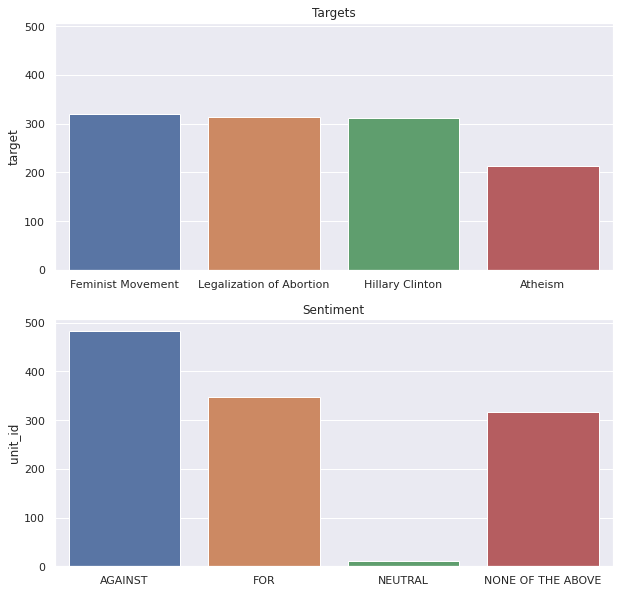

In [ ]:
fig, axes = plt.subplots(2, 1, figsize=(10, 10), sharey=True)
sns.barplot(y=pd.Series(database['target']).value_counts().transpose(), x=pd.Series(database['target']).value_counts().index, ax=axes[0])
sns.barplot(y=database.groupby(by='q1r').count().transpose().iloc[0,:], x=['AGAINST', 'FOR', 'NEUTRAL', 'NONE OF THE ABOVE'], ax=axes[1])
axes[0].set_title('Targets')
axes[1].set_title('Sentiment')
plt.show()

## q1

In [ ]:
#Answers to Q1
print(database['q1r'].unique())
print(database['q1_confidence'].describe())

['AGAINST' 'NONE OF THE ABOVE' 'FOR' 'NEUTRAL']
count    1159.000000
mean        0.780270
std         0.195433
min         0.257500
25%         0.622500
50%         0.814300
75%         1.000000
max         1.000000
Name: q1_confidence, dtype: float64


## q2

In [ ]:
#Answers to Q2
print(database['q2'].unique())
print(database['q2_confidence'].describe())

['2. The tweet does NOT expresses opinion about the target but it HAS opinion about something or someone other than the target.'
 '1.  The tweet explicitly expresses opinion about the target, a part of the target, or an aspect of the target.'
 '3.  The tweet is not explicitly expressing opinion. (For example, the tweet is simply giving information.)']
count    1159.000000
mean        0.721863
std         0.195343
min         0.373200
25%         0.517150
50%         0.740700
75%         0.882750
max         1.000000
Name: q2_confidence, dtype: float64


## WordCloud

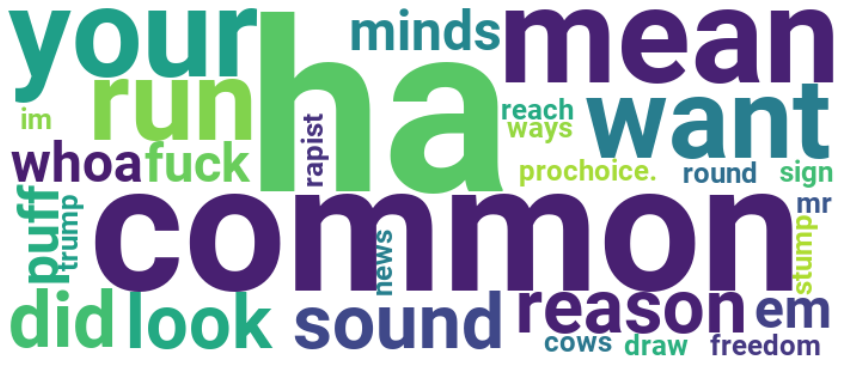

In [ ]:
!pip install multidict
import multidict as multidict
import re
  
def plot_word_cloud(text) :
    # Définir le calque du nuage des mots
    wc = WordCloud(width=700,height=300,background_color="white", max_words=30, font_path='gdrive/MyDrive/NLP_Project/Roboto-Bold.ttf',
                   stopwords=stop_words, max_font_size=200,collocations = False, random_state=42)
    # Générer et afficher le nuage de mots
    plt.figure(figsize= (15,20))
    wc.generate_from_frequencies(text)
    plt.imshow(wc, interpolation="bilinear")
    plt.axis("off")
    plt.show()


def getFrequencyDictForText(sentence):
    fullTermsDict = multidict.MultiDict()
    tmpDict = {}

    # making dict for counting frequencies
    for text in sentence.split(" "):
        if re.match("a|the|an|the|to|in|for|of|or|by|with|is|on|that|be|=|\[|\]$|#|\*$|removed\]|her\*|&", text):
            continue
        val = tmpDict.get(text, 0)
        tmpDict[text.lower()] = val + 1
    for key in tmpDict:
        fullTermsDict.add(key, tmpDict[key])
    return fullTermsDict
# Faire un nuage de mot 
# Analyser les langues des tweets 
stop_words = stopwords.words('english')
freq_dict = {}
for sent in database['tweet'].values:
  freq_dict.update(getFrequencyDictForText(sent))

plot_word_cloud(freq_dict)

## Valeurs manquantes 

In [ ]:
database.isna().sum()

unit_id                                                                                                                                                 0
golden                                                                                                                                                  0
unit_state                                                                                                                                              0
trusted_judgments                                                                                                                                       0
last_judgment_at                                                                                                                                       69
q1                                                                                                                                                      0
q1_confidence                                                               

# 2) Word2Vec

In [ ]:
import nltk
from tqdm import tqdm
from gensim.models import Word2Vec
from multiprocessing import cpu_count
from gensim.models.phrases import Phrases, Phraser
from gensim.models.phrases import Phrases, Phraser
from nltk.tokenize import TreebankWordTokenizer, TweetTokenizer
nltk.download('punkt')
sent_detector = nltk.data.load('tokenizers/punkt/english.pickle')

from sklearn.feature_extraction.text import CountVectorizer
from sklearn import preprocessing

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


## Text cleaning

In [ ]:
#Suppression des hashtags
def remove_hashtags(tokens):
    tokens = map(lambda x: x.replace('#', ''), tokens)
    tokens = map(lambda x: x.replace('.', ''), tokens)
    return list(tokens)

#Suppression des url
def remove_url(tokens):
    tokens = filter(lambda x: "http" not in x, tokens)
    return list(tokens)

def remove_html(tokens):
    tokens = filter(lambda x: x[0]+x[-1] != '<>', tokens)
    return list(tokens)

def tokenize_url_hashtags(corpus, tweets=False):
    if tweets:
        tokenizer = TweetTokenizer()
    else:
        tokenizer = TreebankWordTokenizer()  
    # Life hack : treebank word tokenizer won't keep html code in one token.
    # To preprocess economics news corpus, use tweettokenizer. 
    tokenized_sentences = []
    for sample in tqdm(corpus):
    # separating sentences
        for sentence in sent_detector.tokenize(sample):
            tokens = tokenizer.tokenize(sentence)
            tokens = remove_url(tokens)
            tokens = remove_html(tokens)
            tokens = remove_hashtags(tokens)
            tokens = list(map(lambda x: x.lower(), tokens))
            tokenized_sentences.append(tokens)
    return tokenized_sentences


def clean_corpus(corpus, threshold=50, tweets=False):
    tokenized_sentences = tokenize_url_hashtags(corpus, tweets=tweets)
    phrases = Phrases(tokenized_sentences, threshold=threshold)

  # This lets you use it with less RAM and faster processing.
  # But it will no longer be possible to update the detector with new training 
  # samples
    phraser = Phraser(phrases)

  # Merging multi-word expressions in the tokenization
    clean_corpus = []
    for sentence in tokenized_sentences:
        clean_corpus.append(phraser[sentence])
    return clean_corpus

from gensim.models.phrases import Phrases, Phraser

def show_phrases(tokenized_sentences, threshold=10, shown=15):
  # Training the multi-word expression detector
  phrases = Phrases(tokenized_sentences, threshold=threshold)
  i = 0
  for phrase, score in phrases.export_phrases(tokenized_sentences):
    if i>shown:
      break
    else:
      print("Expression : {0}, score = {1}".format(phrase, score))
    i=i+1

def detokenize_url_hashtags(corpus):
    tokenizer = TweetTokenizer() 
    # Life hack : treebank word tokenizer won't keep html code in one token.
    # To preprocess economics news corpus, use tweettokenizer. 
    tokenized_sentences = []
    for sample in tqdm(corpus):
          tokens = tokenizer.tokenize(sample)
          tokens = remove_url(tokens)
          tokens = remove_html(tokens)
          tokens = remove_hashtags(tokens)
          tokens = list(map(lambda x: x.lower(), tokens))
          tokenized_sentences.append(' '.join(tokens))
    return tokenized_sentences

def clean_corpus2(corpus, threshold=50):
    tokenized_sentences = tokenize_url_hashtags(corpus)
    phrases = Phrases(tokenized_sentences, threshold=threshold)

    phraser = Phraser(phrases)

    clean_corpus = []
    for sentence in tokenized_sentences:
        clean_corpus.append(phraser[sentence])
    return clean_corpus

In [ ]:
cleaned_pol = tokenize_url_hashtags(database.tweet.array, tweets=True)
print('number of pol:', len(cleaned_pol))

100%|██████████| 1159/1159 [00:00<00:00, 6568.27it/s]

number of pol: 2134


In [ ]:
cleaned_tweets = detokenize_url_hashtags(database.tweet)

100%|██████████| 1159/1159 [00:00<00:00, 12440.40it/s]


In [ ]:
database['cleaned_tweets']=cleaned_tweets

In [ ]:
show_phrases(cleaned_pol, threshold=10)

Expression : b'the same', score = 19.070697220867867
Expression : b'pray for', score = 25.283775048480933
Expression : b'to kill', score = 13.837499999999999
Expression : b'i am', score = 49.463229571984435
Expression : b'want to', score = 11.616666666666667
Expression : b'i am', score = 49.463229571984435
Expression : b'no matter', score = 60.73602484472049
Expression : b'people who', score = 39.803934871099045
Expression : b'have been', score = 10.651960784313724
Expression : b'ready for', score = 44.821237585943464
Expression : b'marcorubio in', score = 36.77115229653505
Expression : b'a woman', score = 18.246564885496184
Expression : b'hillary clinton', score = 122.57948717948719
Expression : b'too many', score = 75.21923076923078
Expression : b'too many', score = 75.21923076923078
Expression : b'the same', score = 19.070697220867867


In [ ]:
print(cleaned_pol[106]) 

["it's", 'time', 'that', 'we', 'move', 'from', 'good', 'words', '2', 'good', 'works', ',', 'from', 'sound', 'bites', '2', 'sound', 'solutions', 'hillary', 'clinton', 'hillaryclinton']


Hillary Clinton is a multilingual expression. According to the following tweet, it was indeed considered so. 

## Training Word2Vec model 


In [ ]:
cpu = cpu_count()
print('The virtual instance has {} cpus, that will be used to train the word2vec model'.format(cpu))

The virtual instance has 2 cpus, that will be used to train the word2vec model


In [ ]:
# We will just get the "WordVectors" parameter from the trained Word2Vec model.
# Otherwise, we could continue training with some more exemples that could be
# fed on the fly to the model.
print("Training the political W2V ...")
pol = Word2Vec(cleaned_pol, size=100, window=5, min_count=1, workers=cpu, sg=0)
pol.train(cleaned_pol, total_examples=len(cleaned_pol), epochs=100)
pol_wv = pol.wv

Training the political W2V ...


In [ ]:
def tokens2vectors(tokenCorpus, trained_word2vec, dim=100):
    new_sample = list()
    for sample in tokenCorpus:
        tweetVecs = list()
        for token in sample.split(' '):
            try: tweetVecs.append(trained_word2vec.get_vector(token)  )
            except: tweetVecs.append( np.zeros(dim) ) 
        new_sample.append(np.mean(tweetVecs, axis=0))
    return np.array(new_sample)

In [ ]:
X = tokens2vectors(database.loc[:, "tweet"], pol_wv)
print(X.shape)
print(len(database.loc[:, "tweet"]))

(1159, 100)
1159


In [ ]:
print(X)

[[-0.03761096  0.09020913  0.35451519 ...  0.00703612  0.3112482
   0.64487062]
 [ 0.00244321  0.06173131  0.44070381 ... -0.19130145 -0.3203484
   0.01160153]
 [-0.03748266  0.10162174  0.33778896 ...  0.46077756  0.41992016
   0.10389539]
 ...
 [-0.17044922  0.14558596  0.26151944 ...  0.03106213  0.15946563
   0.0278331 ]
 [-0.06933485  0.25518062  0.17470395 ... -0.0566236   0.37166669
   0.29277746]
 [-0.38870319  0.29793313  0.2094042  ...  0.2267975  -0.01161576
   0.74975769]]


## Sentiment models

In [ ]:
Xseries = pd.DataFrame(X)

### Train test split

In [ ]:
le = preprocessing.LabelEncoder()
database['q1rE'] = le.fit_transform(database.q1r)

X_train, X_1, y_train, y_1, idx_train, idxx = train_test_split(Xseries, database.q1rE, np.arange(len(database)), test_size=0.33, random_state=42)
train_df = pd.DataFrame(X_train, y_train)

X_val, X_test, y_val, y_test, idx_val, idx_test = train_test_split(X_1, y_1,idxx,  test_size=0.5, random_state=42)
test_df = pd.DataFrame(X_test, y_test)
val_df = pd.DataFrame(X_val, y_val)

In [ ]:
le_classes = le.classes_
le_classes

array(['AGAINST', 'FOR', 'NEUTRAL', 'NONE OF THE ABOVE'], dtype=object)

In [ ]:
print(train_df.shape, val_df.shape, test_df.shape)

(776, 100) (191, 100) (192, 100)


In [ ]:
X_train.head()

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31,32,33,34,35,36,37,38,39,...,60,61,62,63,64,65,66,67,68,69,70,71,72,73,74,75,76,77,78,79,80,81,82,83,84,85,86,87,88,89,90,91,92,93,94,95,96,97,98,99
254,-0.280933,0.465987,0.333721,-0.366071,0.023209,0.085242,0.076369,-0.407559,-0.109585,-0.345017,0.132137,-0.171983,0.060339,-0.121580,0.070466,0.005507,0.183104,-0.484523,0.058208,0.077478,0.018413,-0.350091,-0.254845,-0.133311,-0.166461,-0.184851,0.210750,0.079313,-0.016620,-0.107974,-0.121726,0.080847,0.089969,-0.092673,-0.092305,0.180109,0.111090,0.352969,0.317004,-0.119615,...,-0.151647,-0.046147,0.201566,-0.231454,0.176279,-0.008181,-0.119900,0.181870,-0.276439,-0.669164,-0.249587,-0.115770,-0.217403,-0.314232,-0.121545,0.570825,-0.201249,-0.221405,-0.056467,-0.015537,0.262113,0.130279,0.220679,0.297082,0.104610,-0.243266,-0.031876,0.020997,0.006500,-0.215606,-0.420542,-0.265852,-0.043863,0.230665,0.006978,-0.052351,0.250017,0.133587,-0.063536,0.280168
881,-0.125200,0.280737,0.258233,-0.552306,0.231725,0.321058,0.193599,-0.054897,-0.031658,-0.502294,0.318017,0.218063,-0.071344,-0.383464,0.456419,-0.231007,0.459239,-0.379478,0.504288,0.094471,0.584499,-0.307988,-0.376000,-0.225896,-0.294056,0.014108,0.190175,-0.105348,0.063606,0.009552,-0.395595,0.015764,0.172797,-0.013317,-0.219544,0.236243,-0.112928,0.275314,0.619687,-0.070419,...,-0.105670,-0.357374,0.365882,0.137615,0.198863,0.019714,-0.078197,-0.087221,-0.250718,-0.486853,-0.176498,-0.083486,0.041446,-0.431989,-0.143141,0.500281,-0.568980,-0.124715,-0.042932,0.101961,0.131443,-0.350836,0.209955,-0.186913,0.144958,-0.024830,-0.185834,0.001300,0.113356,-0.138810,-0.509441,-0.360100,-0.030952,0.315341,-0.023608,-0.422252,0.485154,-0.066936,-0.000818,0.321004
312,-0.327678,0.477555,0.308201,-0.563821,0.186975,0.288124,0.124733,-0.319373,-0.092439,-0.475874,0.239975,-0.082558,0.281206,-0.293203,0.170351,-0.105791,0.428482,-0.542650,0.238310,0.022216,-0.054070,-0.208656,-0.175834,-0.206009,-0.334944,-0.203144,0.340048,0.025401,-0.352637,-0.089416,-0.174718,0.163488,0.098250,0.249251,-0.237938,0.217620,-0.148573,0.085049,0.314359,-0.040665,...,-0.152029,-0.369345,0.107517,0.078818,0.027507,-0.081453,-0.156403,0.399321,-0.412695,-0.717464,-0.143015,-0.115222,-0.356504,-0.497374,-0.134912,0.435628,-0.251400,-0.065016,-0.016455,-0.062483,0.237794,0.113003,0.399250,0.308019,-0.116358,-0.100642,-0.142825,-0.081828,-0.024258,-0.096147,-0.279328,-0.441651,-0.107570,0.489549,0.112684,-0.090452,0.310660,0.011111,0.086265,-0.019359
451,-0.879477,0.474133,0.487268,-0.557664,0.028019,0.292079,0.616811,-0.655217,-0.306107,-0.685360,0.493131,-0.434374,-0.019663,-0.050866,-0.031262,0.234732,0.434949,-0.404190,-0.057863,0.003972,0.104644,-0.196835,-0.413069,-0.070253,-0.319631,-0.380405,0.404955,-0.049830,0.282982,0.102238,-0.468842,0.256815,0.089816,-0.013912,-0.057166,0.075009,-0.011804,0.171859,0.141670,0.037261,...,-0.139466,-0.105372,0.280371,-0.524961,0.152065,0.011376,-0.156704,0.085381,-0.033870,-0.577298,-0.156252,-0.357051,0.133658,-0.173276,-0.277820,0.371640,-0.168428,-0.246618,0.029613,-0.152771,0.739487,-0.060196,0.297444,0.402315,-0.151857,-0.362677,0.008279,-0.197040,-0.151142,-0.453686,-0.416922,-0.274118,0.052754,-0.259255,0.298934,-0.287854,0.408048,0.214507,-0.036935,0.187185
221,-0.317453,0.186028,0.275140,-0.639119,-0.265714,0.169861,0.215293,-0.977982,-0.435608,-0.467385,0.255271,-0.463889,0.232329,0.111549,-0.084294,0.539832,-0.088616,-0.377801,-0.315191,0.504023,-0.075096,-0.309834,-0.386371,0.022341,-0.085143,-0.259372,0.203403,0.157312,-0.113934,-0.485308,-0.237620,-0.269452,0.524210,-0.309832,-0.213167,0.112608,0.310929,-0.098370,-0.001713,0.391188,...,-0.131287,-0.134112,-0.221710,0.000018,0.351914,0.272603,-0.386775,0.163890,-0.247625,-0.769390,-0.503406,0.178066,0.451837,-0.031177,-0.465417,0.783639,-0.349833,-0.067366,0.168591,0.230297,0.174912,0.313052,0.374445,0.305066,-0.097742,-0.084009,0.028422,-0.048622,-0.331362,-0.439

In [ ]:
y_train.head()

254    3
881    1
312    0
451    1
221    0
Name: q1rE, dtype: int64

In [ ]:
models = [
    ('knn', KNeighborsClassifier()),
        ("logreg", LogisticRegression(max_iter=5000, random_state=1)),
         ("RF", RandomForestClassifier(n_estimators=100, max_depth=10, random_state=1))]

grids = {"knn" : {'knn__n_neighbors': [1, 2, 3, 4, 5]},
        "logreg" : {'logreg__C': np.logspace(-2, 2, 5, base=2)
                    }, 
         "RF" : {'RF__n_estimators' : np.arange(60,400,30),
                 'RF__max_depth': np.arange(7, 13)
                }
        }

for name, model in models:
    pipe = Pipeline(steps=[(name, model)])
    clf = GridSearchCV(pipe, grids[name], cv=3)
    clf.fit(X_train, y_train) 
    print('Returned hyperparameter: {}'.format(clf.best_params_))
    print('Best classification accuracy in train is: {}'.format(clf.best_score_))
    print('Classification accuracy on test is: {}'.format(clf.score(X_test, y_test)))
    print()

Returned hyperparameter: {'knn__n_neighbors': 2}
Best classification accuracy in train is: 0.3891832031366915
Classification accuracy on test is: 0.390625

Returned hyperparameter: {'logreg__C': 2.0}
Best classification accuracy in train is: 0.4239472030169705
Classification accuracy on test is: 0.4166666666666667

Returned hyperparameter: {'RF__max_depth': 7, 'RF__n_estimators': 180}
Best classification accuracy in train is: 0.4227001087466204
Classification accuracy on test is: 0.4010416666666667



In [ ]:
def show_confusion_matrix(confusion_matrix, legend_text):
  hmap = sns.heatmap(confusion_matrix, annot=True, fmt="d", cmap="Blues")
  hmap.yaxis.set_ticklabels(hmap.yaxis.get_ticklabels(), rotation=0, ha='right')
  hmap.xaxis.set_ticklabels(hmap.xaxis.get_ticklabels(), rotation=30, ha='right')
  plt.ylabel('True '+legend_text)
  plt.xlabel('Predicted '+legend_text)
  plt.show()

In [ ]:
best_logreg = LogisticRegression(max_iter=5000, C=0.5, random_state=1)
pipe1 = Pipeline(steps=[('LogisticRegression', best_logreg)])
pipe1.fit(X_train, y_train)
y_pred = pipe1.predict(X_test)

Balanced Accuracy: 0.31353820598006643


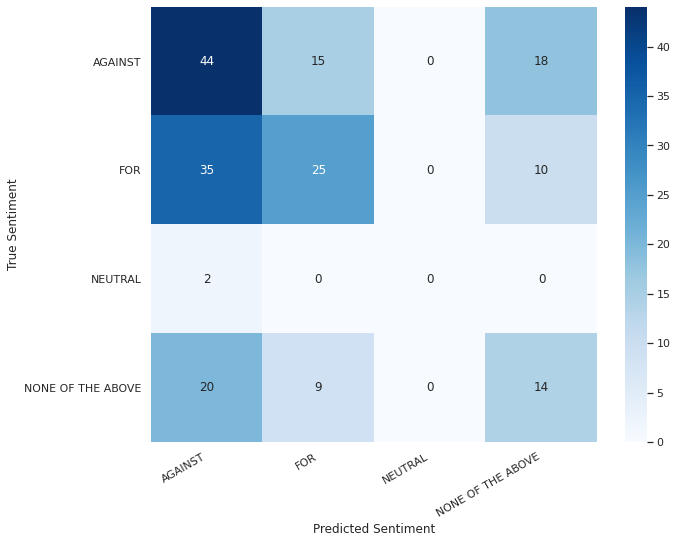

                   precision    recall  f1-score   support

          AGAINST       0.44      0.57      0.49        77
              FOR       0.51      0.36      0.42        70
          NEUTRAL       0.00      0.00      0.00         2
NONE OF THE ABOVE       0.33      0.33      0.33        43

         accuracy                           0.43       192
        macro avg       0.32      0.31      0.31       192
     weighted avg       0.44      0.43      0.43       192



/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


In [ ]:
print("Balanced Accuracy:",balanced_accuracy_score(y_test,y_pred))

plt.figure(figsize=(10,8))
cmW2V_Sent = confusion_matrix(y_test, y_pred)
df_cmW2V_Sent = pd.DataFrame(cmW2V_Sent, index= le_classes, columns=le_classes)
show_confusion_matrix(df_cmW2V_Sent, 'Sentiment')

print(classification_report(y_test, y_pred, target_names = le_classes))

## Aspect classification

In [ ]:
leAspect = preprocessing.LabelEncoder()
database['targetEncoded'] = leAspect.fit_transform(database.target)

X_trainAspect = X[idx_train]
y_trainAspect = database.targetEncoded[idx_train]

X_valAspect = X[idx_val]
y_valAspect = database.targetEncoded[idx_val]

X_testAspect = X[idx_test]
y_testAspect = database.targetEncoded[idx_test]

trainAspect_df = pd.DataFrame(X_trainAspect, y_trainAspect)
testAspect_df = pd.DataFrame(X_testAspect, y_testAspect)
valAspect_df = pd.DataFrame(X_valAspect, y_valAspect)

In [ ]:
le_classesAspect = leAspect.classes_
le_classesAspect

array(['Atheism', 'Feminist Movement', 'Hillary Clinton',
       'Legalization of Abortion'], dtype=object)

In [ ]:
print(trainAspect_df.shape, valAspect_df.shape, testAspect_df.shape)

(776, 100) (191, 100) (192, 100)


In [ ]:
for name, model in models:
    pipe = Pipeline(steps=[(name, model)])
    clf = GridSearchCV(pipe, grids[name], cv=3)
    clf.fit(X_trainAspect, y_trainAspect) 
    print('Returned hyperparameter: {}'.format(clf.best_params_))
    print('Best classification accuracy in train is: {}'.format(clf.best_score_))
    print('Classification accuracy on test is: {}'.format(clf.score(X_testAspect, y_testAspect)))
    print()

Returned hyperparameter: {'knn__n_neighbors': 4}
Best classification accuracy in train is: 0.34792433629642927
Classification accuracy on test is: 0.3645833333333333

Returned hyperparameter: {'logreg__C': 4.0}
Best classification accuracy in train is: 0.45363303502838387
Classification accuracy on test is: 0.4947916666666667

Returned hyperparameter: {'RF__max_depth': 9, 'RF__n_estimators': 270}
Best classification accuracy in train is: 0.43040216296030254
Classification accuracy on test is: 0.5



In [ ]:
best_logreg2 = LogisticRegression(max_iter=5000, C=1.0, random_state=1)
pipe2 = Pipeline(steps=[('LogisticRegression', best_logreg2)])
pipe2.fit(X_trainAspect, y_trainAspect)

Pipeline(memory=None,
         steps=[('LogisticRegression',
                 LogisticRegression(C=1.0, class_weight=None, dual=False,
                                    fit_intercept=True, intercept_scaling=1,
                                    l1_ratio=None, max_iter=5000,
                                    multi_class='auto', n_jobs=None,
                                    penalty='l2', random_state=1,
                                    solver='lbfgs', tol=0.0001, verbose=0,
                                    warm_start=False))],
         verbose=False)

Balanced Accuracy: 0.4859730629539951


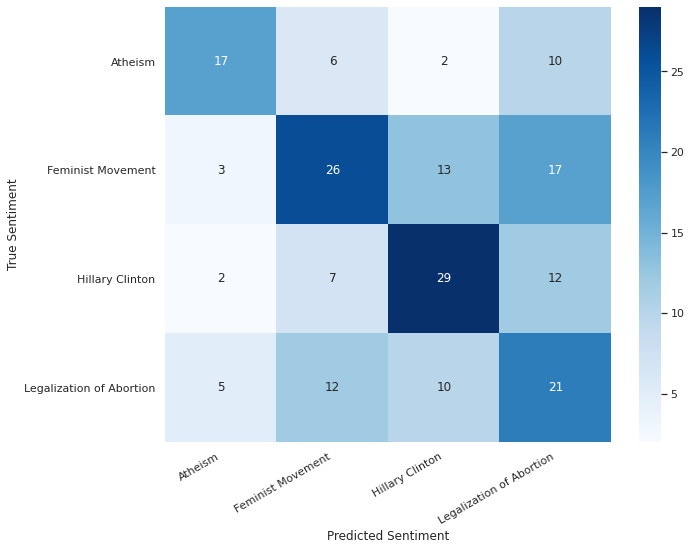

                          precision    recall  f1-score   support

                 Atheism       0.63      0.49      0.55        35
       Feminist Movement       0.51      0.44      0.47        59
         Hillary Clinton       0.54      0.58      0.56        50
Legalization of Abortion       0.35      0.44      0.39        48

                accuracy                           0.48       192
               macro avg       0.51      0.49      0.49       192
            weighted avg       0.50      0.48      0.49       192



In [ ]:
y_predAspect = pipe2.predict(X_testAspect)
print("Balanced Accuracy:",balanced_accuracy_score(y_testAspect,y_predAspect))
cnf_matrix = confusion_matrix(y_testAspect, y_predAspect)

plt.figure(figsize=(10,8))
cmW2V_Aspect = confusion_matrix(y_testAspect, y_predAspect)
df_cmW2V_Aspect = pd.DataFrame(cmW2V_Aspect, index= le_classesAspect, columns=le_classesAspect)
show_confusion_matrix(df_cmW2V_Aspect, 'Sentiment')


print(classification_report(y_testAspect, y_predAspect, target_names = le_classesAspect))

# 3) BERT for Sentiment Classification

## Training

In [ ]:
!pip install transformers
import pdb
import torch
import torch.nn as nn
from transformers import AutoModel, AutoTokenizer, AutoModelWithLMHead, AutoModel
from torch.utils.data import Dataset, DataLoader, TensorDataset
from sklearn.model_selection import train_test_split
import torch.optim as optim

In [ ]:
X_train = database.cleaned_tweets[idx_train]
y_train = database.q1rE[idx_train]

X_val = database.cleaned_tweets[idx_val]
y_val = database.q1rE[idx_val]

X_test = database.cleaned_tweets[idx_test]
y_test = database.q1rE[idx_test]

train_df = pd.DataFrame({'sentence':X_train, 'label':y_train})
test_df = pd.DataFrame({'sentence':X_test, 'label':y_test})
val_df = pd.DataFrame({'sentence':X_val, 'label':y_val})

In [ ]:
print(train_df.shape, val_df.shape, test_df.shape)

(776, 2) (191, 2) (192, 2)


In [ ]:
class ProgressiveIssuesDataSet(Dataset):

    def __init__(self, dataset, maxlen, model_name='bert-base-uncased'):

        #Initialize the BERT tokenizer
        self.tokenizer = AutoTokenizer.from_pretrained(model_name)
        self.dataset = dataset
        self.maxlen = maxlen
        
    def __len__(self):
        return len(self.dataset)
    
    def __getitem__(self, index):
        
        #print("INDEX selected:", index)
        #Selecting the sentence and label at the specified index in the data frame
        sentence = self.dataset.loc[index,'sentence']
        label = self.dataset.loc[index, 'label']
        
       
        #Preprocessing the text to be suitable for BERT
        tokens = self.tokenizer.tokenize(sentence) #Tokenize the sentence
        if self.tokenizer.cls_token is None:
            bos_token = self.tokenizer.bos_token
        else:
            bos_token = self.tokenizer.cls_token
          
        if self.tokenizer.sep_token is None:
            eos_token = self.tokenizer.eos_token
        else:
            eos_token = self.tokenizer.sep_token
        
        tokens = [bos_token] + tokens + [eos_token] #Insering the CLS and SEP token in the beginning and end of the sentence
        if len(tokens) < self.maxlen:
            tokens = tokens + [self.tokenizer.pad_token for _ in range(self.maxlen - len(tokens))] #Padding sentences
        else:
            tokens = tokens[:self.maxlen-1] + [eos_token] #Prunning the list to be of specified max length

        tokens_ids = self.tokenizer.convert_tokens_to_ids(tokens) #Obtaining the indices of the tokens in the BERT Vocabulary
        tokens_ids_tensor = torch.tensor(tokens_ids) #Converting the list to a pytorch tensor
        #Obtaining the attention mask i.e a tensor containing 1s for no padded tokens and 0s for padded ones
        attn_mask = (tokens_ids_tensor != 0).long()

        return tokens_ids_tensor, attn_mask, label

In [ ]:
#Creating instances of training and validation set
train_set = ProgressiveIssuesDataSet(train_df.reset_index(drop=True), maxlen=30,  model_name='bert-base-uncased')
val_set = ProgressiveIssuesDataSet(val_df.reset_index(drop=True), maxlen=30, model_name='bert-base-uncased')
test_set = ProgressiveIssuesDataSet(test_df.reset_index(drop=True), maxlen=30, model_name='bert-base-uncased')

In [ ]:
train_set.dataset.loc[0, 'sentence']

"fact : 17 % of today's population is equivalent to residents in new york , florida , and pennsylvania  where's the outrage for this ?"

In [ ]:
train_set.dataset.loc[0, 'label']

3

In [ ]:
train_set.__getitem__(0)

(tensor([  101,  2755,  1024,  2459,  1003,  1997,  2651,  1005,  1055,  2313,
          2003,  5662,  2000,  3901,  1999,  2047,  2259,  1010,  3516,  1010,
          1998,  3552,  2073,  1005,  1055,  1996, 19006,  2005,  2023,   102]),
 tensor([1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
         1, 1, 1, 1, 1, 1]),
 3)

In [ ]:
#Creating intsances of training and validation dataloaders
train_loader = DataLoader(train_set, batch_size = 12, num_workers = 1)
val_loader = DataLoader(val_set, batch_size = 12, num_workers = 1)
test_loader = DataLoader(test_set, batch_size = 12, num_workers = 1)

In [ ]:
train_iter = iter(train_loader)
print(type(train_iter))

<class 'torch.utils.data.dataloader._MultiProcessingDataLoaderIter'>


In [ ]:
class SentimentClassifier(nn.Module):

    def __init__(self, pretrained_model_name='bert-base-uncased'):
        super(SentimentClassifier, self).__init__()
        
        #Loading Mask Language Model 
        self.encoder = AutoModel.from_pretrained(pretrained_model_name)
        #we append an extra layer for Classification (it will be randomly initialized)
        self.cls_layer = nn.Linear(self.encoder.pooler.dense.out_features, 4)

    def forward(self, seq, attn_masks):
        '''
        Inputs:
            -seq : Tensor of shape [B, T] containing token ids of sequences
            -attn_masks : Tensor of shape [B, T] containing attention masks to be used to avoid contibution of PAD tokens
        '''

        #Feeding the input to BERT model to obtain contextualized representations
        # see in the hugging face doc what to input
        #cont_reps = #  self.encoder(..)..
        cont_reps = self.encoder(seq, attention_mask = attn_masks)
        #Obtaining the representation of [CLS] head
        pool = cont_reps["pooler_output"]

        #Feeding cls_rep to the classifier layer
        output = self.cls_layer(pool)

        return output


In [ ]:
sentiment_model = SentimentClassifier('bert-base-uncased')

In [ ]:
# define the loss and optimizer 
criterion = nn.CrossEntropyLoss()
opti = optim.Adam(sentiment_model.parameters(), lr = 1e-4)

In [ ]:
def train(model, criterion, opti, train_loader, val_loader, max_eps=1, print_every=1,validate_every=1, break_training_after=None, gpu=False):
    for ep in range(max_eps):
        print('Epoch : {}/{}'.format(ep+1, max_eps))   
        for it, (seq, attn_masks, labels) in tqdm(list(enumerate(train_loader))):
            #Clear gradients
            opti.zero_grad()  
    
            #Obtaining the outputs from the model
            outputs = model(seq, attn_masks)

            #Computing loss
            loss = criterion(outputs, labels)

            #Backpropagating the gradients
            loss.backward()

            #Optimization step
            opti.step()

            preds = torch.max(outputs, dim=1)
            correct_predictions = torch.sum(preds.indices == labels)
            

            if (it + 1) % print_every == 0:
                accuracy = correct_predictions /float(labels.size(0))
                #print("Iteration {} of epoch {} complete. Loss : {}, Accuracy {} ".format(it+1, ep+1, loss.item(),accuracy))
            if break_training_after is not None and it>break_training_after:
                print("Early breaking : did not cover a full epoch but only {} iteration ".format(it))
                break
        if ep % validate_every==0:
            print("Iteration {} of epoch {} complete. Loss : {}, Accuracy {} ".format(it+1, ep+1, loss.item(),accuracy))
          # evaluation on the validation set
            n_batch_validation = 0
            loss_validation = 0
            accuracy_validation = 0
            for it, (seq, attn_masks, labels) in enumerate(val_loader):            
              #Obtaining the logits from the model
              logits_val = model(seq, attn_masks)
              n_batch_validation+=1
              preds_val = torch.max(logits_val, dim=1)
              correct_predictions_val = torch.sum(preds_val.indices == labels)
              #Computing loss
              _loss = float(criterion(logits_val, labels))
              _accu = correct_predictions_val/float(labels.size(0))
  
              loss_validation += _loss
              accuracy_validation += _accu
        print("EVALUATION Validation set : mean loss {} n mean accuracy {}".format(loss_validation/n_batch_validation, accuracy_validation/n_batch_validation))
    return _loss
          

In [260]:
train(sentiment_model, criterion, opti, train_loader, val_loader, max_eps=5, print_every=10)

Epoch : 1/5


100%|██████████| 65/65 [03:08<00:00,  2.90s/it]

Iteration 65 of epoch 1 complete. Loss : 0.798469066619873, Accuracy 0.6666666865348816 


EVALUATION Validation set : mean loss 1.0464677214622498 n mean accuracy 0.5388257503509521
Epoch : 2/5


100%|██████████| 65/65 [02:58<00:00,  2.75s/it]

Iteration 65 of epoch 2 complete. Loss : 0.5665708184242249, Accuracy 0.6666666865348816 


EVALUATION Validation set : mean loss 1.2095624543726444 n mean accuracy 0.544981062412262
Epoch : 3/5


100%|██████████| 65/65 [02:56<00:00,  2.71s/it]

Iteration 65 of epoch 3 complete. Loss : 0.44731080532073975, Accuracy 0.8333333134651184 


EVALUATION Validation set : mean loss 0.9815954826772213 n mean accuracy 0.5667613744735718
Epoch : 4/5


100%|██████████| 65/65 [02:57<00:00,  2.73s/it]

Iteration 65 of epoch 4 complete. Loss : 0.027916502207517624, Accuracy 1.0 


EVALUATION Validation set : mean loss 1.2050055656582117 n mean accuracy 0.6373105645179749
Epoch : 5/5


100%|██████████| 65/65 [03:04<00:00,  2.84s/it]

Iteration 65 of epoch 5 complete. Loss : 0.01673671416938305, Accuracy 0.9166666865348816 


EVALUATION Validation set : mean loss 1.3374851420521736 n mean accuracy 0.5904356241226196


1.4953235387802124

## Predictions on test data

In [261]:
def get_predictions(model, data_loader, test_set):
  model = model.eval()

  review_texts = []
  predictions = []
  prediction_probs = []
  real_values = []

  with torch.no_grad():
    for it, (seq, attn_masks, labels) in tqdm(list(enumerate(test_loader))):
      tweet = test_set.dataset.loc[it, 'sentence']
      outputs = model(
        seq=seq,
        attn_masks= attn_masks
      )

      _, preds = torch.max(outputs, dim=1)


      review_texts.extend(tweet)
      predictions.extend(preds)
      prediction_probs.extend(outputs)
      real_values.extend(labels)

  predictions = torch.as_tensor(predictions)
  real_values = torch.stack(real_values)
  return review_texts, predictions, prediction_probs, real_values

In [262]:
review_texts, predictions, prediction_probs, real_values = get_predictions(sentiment_model, data_loader=test_loader, test_set= test_set)

100%|██████████| 16/16 [00:11<00:00,  1.43it/s]


In [263]:
predictions

tensor([0, 0, 0, 0, 0, 0, 1, 3, 0, 0, 0, 0, 3, 0, 1, 3, 1, 1, 0, 0, 0, 0, 0, 1,
        0, 0, 1, 0, 0, 3, 0, 0, 0, 1, 0, 0, 3, 0, 0, 0, 3, 0, 0, 3, 0, 1, 0, 0,
        3, 0, 0, 3, 0, 0, 0, 3, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 3, 0, 0, 3, 3, 0,
        3, 0, 0, 0, 3, 0, 0, 3, 0, 0, 3, 0, 0, 0, 0, 3, 0, 0, 0, 1, 0, 1, 0, 3,
        3, 0, 1, 0, 3, 3, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 3, 3, 0, 0, 0, 0, 0, 1,
        0, 1, 3, 0, 0, 3, 0, 0, 3, 3, 1, 0, 0, 0, 3, 0, 3, 3, 1, 3, 0, 0, 0, 0,
        1, 0, 1, 0, 0, 0, 3, 0, 0, 1, 0, 0, 0, 0, 0, 0, 3, 0, 0, 3, 0, 0, 0, 0,
        0, 0, 0, 0, 1, 0, 0, 0, 1, 0, 0, 0, 1, 3, 0, 1, 0, 1, 0, 3, 0, 0, 1, 0])

In [264]:
real_values

tensor([3, 1, 3, 1, 1, 0, 1, 0, 0, 1, 0, 1, 3, 3, 1, 1, 1, 0, 0, 0, 0, 0, 0, 1,
        1, 0, 1, 0, 1, 0, 0, 1, 0, 0, 1, 1, 3, 3, 0, 0, 3, 0, 3, 1, 0, 0, 3, 1,
        3, 0, 1, 0, 0, 1, 1, 3, 0, 2, 0, 0, 1, 0, 0, 0, 0, 1, 3, 0, 3, 3, 3, 0,
        1, 0, 3, 1, 3, 0, 3, 0, 0, 1, 0, 1, 0, 1, 1, 1, 0, 0, 0, 1, 0, 3, 1, 1,
        3, 1, 1, 0, 0, 0, 1, 2, 1, 0, 0, 3, 0, 1, 1, 1, 1, 1, 0, 0, 1, 1, 3, 3,
        3, 1, 0, 0, 0, 0, 1, 1, 3, 3, 1, 1, 0, 1, 1, 1, 3, 3, 1, 1, 0, 0, 1, 1,
        3, 3, 0, 0, 3, 1, 3, 3, 0, 3, 0, 1, 3, 1, 1, 0, 3, 0, 3, 1, 0, 0, 1, 3,
        1, 0, 1, 0, 1, 0, 3, 0, 1, 1, 3, 1, 1, 3, 0, 3, 3, 1, 0, 0, 0, 0, 0, 0])

In [265]:
torch.sum(real_values==predictions) / len(predictions)

tensor(0.4896)

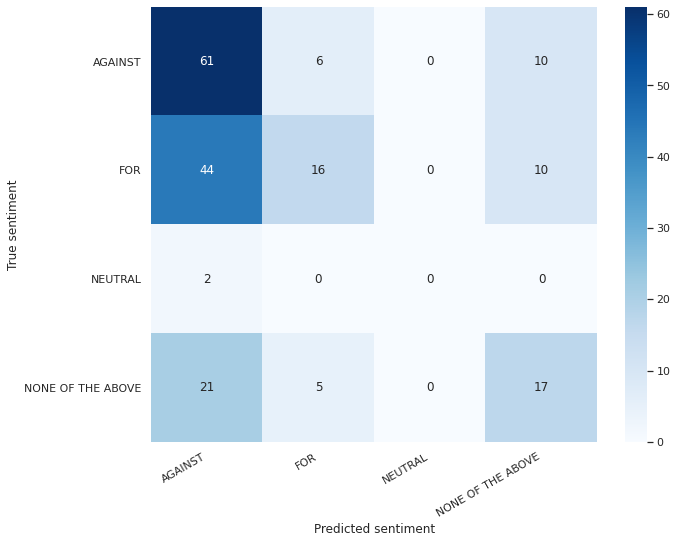

In [266]:
plt.figure(figsize=(10,8))
cm = confusion_matrix(real_values, predictions)
df_cm = pd.DataFrame(cm, index=le_classes, columns=le_classes)
show_confusion_matrix(df_cm, 'sentiment')

# 3) BERT For Aspect Classification (supervised)

## Training

In [267]:
X_trainAspect = database.tweet[idx_train]
y_trainAspect = database.targetEncoded[idx_train]

X_valAspect = database.tweet[idx_val]
y_valAspect = database.targetEncoded[idx_val]

X_testAspect = database.tweet[idx_test]
y_testAspect = database.targetEncoded[idx_test]
 
trainAspect_df = pd.DataFrame({'sentence':X_trainAspect, 'label':y_trainAspect})
testAspect_df = pd.DataFrame({'sentence':X_testAspect, 'label':y_testAspect})
valAspect_df = pd.DataFrame({'sentence':X_valAspect, 'label':y_valAspect})

In [268]:
print(trainAspect_df.shape, valAspect_df.shape, testAspect_df.shape)

(776, 2) (191, 2) (192, 2)


In [269]:
#Creating instances of training and validation set
trainAspect_set = ProgressiveIssuesDataSet(trainAspect_df.reset_index(drop=True), maxlen=30,  model_name='bert-base-uncased')
valAspect_set = ProgressiveIssuesDataSet(valAspect_df.reset_index(drop=True), maxlen=30, model_name='bert-base-uncased')
testAspect_set = ProgressiveIssuesDataSet(testAspect_df.reset_index(drop=True), maxlen=30, model_name='bert-base-uncased')

In [270]:
trainAspect_set.dataset.loc[1, 'sentence']

'Women in Hollywood are still getting paid less. It is 2015.'

In [271]:
le_classesAspect[trainAspect_set.dataset.loc[1, 'label']]

'Feminist Movement'

In [272]:
le_classes[train_set.dataset.loc[1, 'label']]

'FOR'

In [273]:
trainAspect_set.__getitem__(1)

(tensor([ 101, 2308, 1999, 5365, 2024, 2145, 2893, 3825, 2625, 1012, 2009, 2003,
         2325, 1012,  102,    0,    0,    0,    0,    0,    0,    0,    0,    0,
            0,    0,    0,    0,    0,    0]),
 tensor([1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0,
         0, 0, 0, 0, 0, 0]),
 1)

In [274]:
#Creating intsances of training and validation dataloaders
trainAspect_loader = DataLoader(trainAspect_set, batch_size = 12, num_workers = 1)
valAspect_loader = DataLoader(valAspect_set, batch_size = 12, num_workers = 1)
testAspect_loader = DataLoader(testAspect_set, batch_size = 12, num_workers = 1)

In [275]:
aspect_model = SentimentClassifier('bert-base-uncased')

In [276]:
# define the loss and optimizer 
criterion2 = nn.CrossEntropyLoss()
opti2 = optim.Adam(aspect_model.parameters(), lr = 1e-4)

In [277]:
train(aspect_model, criterion2, opti2, trainAspect_loader, valAspect_loader, max_eps=5, print_every=10)

Epoch : 1/5


100%|██████████| 65/65 [03:03<00:00,  2.83s/it]

Iteration 65 of epoch 1 complete. Loss : 0.4459576904773712, Accuracy 0.75 


EVALUATION Validation set : mean loss 0.6193382712081075 n mean accuracy 0.7537879943847656
Epoch : 2/5


100%|██████████| 65/65 [02:55<00:00,  2.71s/it]

Iteration 65 of epoch 2 complete. Loss : 0.5503795742988586, Accuracy 1.0 


EVALUATION Validation set : mean loss 1.190249677747488 n mean accuracy 0.5023674368858337
Epoch : 3/5


100%|██████████| 65/65 [02:55<00:00,  2.70s/it]

Iteration 65 of epoch 3 complete. Loss : 0.045671164989471436, Accuracy 1.0 


EVALUATION Validation set : mean loss 0.7391137070953846 n mean accuracy 0.7750948071479797
Epoch : 4/5


100%|██████████| 65/65 [02:56<00:00,  2.71s/it]

Iteration 65 of epoch 4 complete. Loss : 0.18910057842731476, Accuracy 1.0 


EVALUATION Validation set : mean loss 0.9637982444837689 n mean accuracy 0.7594696879386902
Epoch : 5/5


100%|██████████| 65/65 [02:57<00:00,  2.74s/it]

Iteration 65 of epoch 5 complete. Loss : 0.03034242056310177, Accuracy 1.0 


EVALUATION Validation set : mean loss 1.3366565246833488 n mean accuracy 0.7107006907463074


2.2549142837524414

## Predictions on Test Data

In [278]:
review_textsAspect, predictionsAspect, prediction_probsAspect, real_valuesAspect = get_predictions(aspect_model, data_loader=testAspect_loader, test_set= testAspect_set)

100%|██████████| 16/16 [00:10<00:00,  1.50it/s]


In [279]:
predictionsAspect

tensor([3, 2, 0, 1, 3, 3, 3, 0, 2, 3, 2, 3, 2, 2, 3, 2, 3, 3, 3, 3, 3, 3, 3, 3,
        3, 0, 3, 0, 0, 2, 3, 2, 0, 1, 2, 0, 2, 3, 0, 0, 3, 3, 3, 3, 3, 1, 2, 1,
        3, 2, 2, 1, 2, 1, 2, 3, 1, 2, 3, 0, 3, 3, 0, 2, 0, 3, 2, 3, 2, 2, 3, 2,
        2, 0, 3, 3, 3, 0, 0, 3, 1, 1, 2, 2, 2, 0, 3, 3, 3, 2, 2, 2, 2, 3, 2, 3,
        2, 1, 0, 3, 0, 3, 2, 2, 2, 2, 1, 2, 0, 1, 2, 0, 0, 2, 3, 2, 2, 1, 0, 3,
        2, 1, 0, 2, 1, 3, 1, 1, 2, 2, 0, 2, 0, 3, 0, 2, 3, 2, 3, 3, 0, 2, 3, 1,
        0, 3, 3, 0, 3, 3, 3, 3, 0, 3, 3, 3, 3, 1, 3, 2, 1, 3, 3, 1, 2, 3, 3, 1,
        2, 0, 1, 3, 3, 3, 3, 0, 2, 3, 0, 2, 2, 0, 2, 3, 2, 1, 2, 2, 3, 2, 1, 0])

In [280]:
real_valuesAspect

tensor([3, 1, 3, 1, 1, 0, 1, 0, 0, 1, 0, 1, 3, 3, 1, 1, 1, 0, 0, 0, 0, 0, 0, 1,
        1, 0, 1, 0, 1, 0, 0, 1, 0, 0, 1, 1, 3, 3, 0, 0, 3, 0, 3, 1, 0, 0, 3, 1,
        3, 0, 1, 0, 0, 1, 1, 3, 0, 2, 0, 0, 1, 0, 0, 0, 0, 1, 3, 0, 3, 3, 3, 0,
        1, 0, 3, 1, 3, 0, 3, 0, 0, 1, 0, 1, 0, 1, 1, 1, 0, 0, 0, 1, 0, 3, 1, 1,
        3, 1, 1, 0, 0, 0, 1, 2, 1, 0, 0, 3, 0, 1, 1, 1, 1, 1, 0, 0, 1, 1, 3, 3,
        3, 1, 0, 0, 0, 0, 1, 1, 3, 3, 1, 1, 0, 1, 1, 1, 3, 3, 1, 1, 0, 0, 1, 1,
        3, 3, 0, 0, 3, 1, 3, 3, 0, 3, 0, 1, 3, 1, 1, 0, 3, 0, 3, 1, 0, 0, 1, 3,
        1, 0, 1, 0, 1, 0, 3, 0, 1, 1, 3, 1, 1, 3, 0, 3, 3, 1, 0, 0, 0, 0, 0, 0])

In [281]:
torch.sum(real_valuesAspect==predictionsAspect) / len(predictionsAspect)

tensor(0.3073)

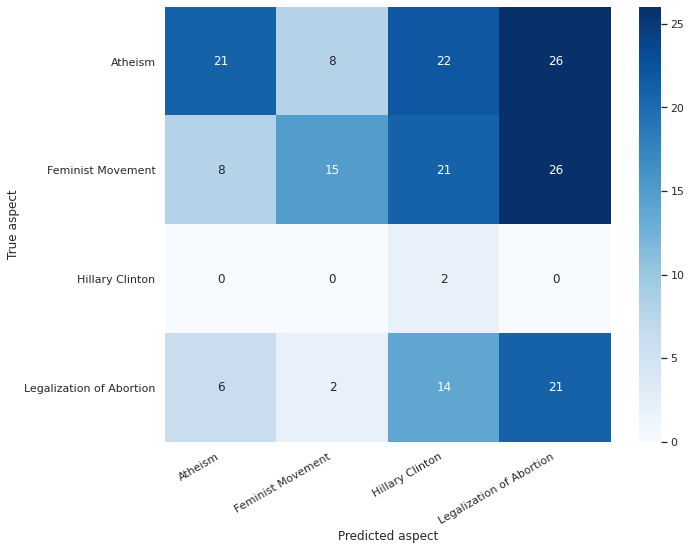

                          precision    recall  f1-score   support

                 Atheism       0.60      0.27      0.37        77
       Feminist Movement       0.60      0.21      0.32        70
         Hillary Clinton       0.03      1.00      0.07         2
Legalization of Abortion       0.29      0.49      0.36        43

                accuracy                           0.31       192
               macro avg       0.38      0.49      0.28       192
            weighted avg       0.52      0.31      0.35       192



In [282]:
plt.figure(figsize=(10,8))
cm = confusion_matrix(real_valuesAspect, predictionsAspect)
df_cm = pd.DataFrame(cm, index= le_classesAspect, columns=le_classesAspect)
show_confusion_matrix(df_cm, 'aspect')
print(classification_report(real_valuesAspect, predictionsAspect, target_names = le_classesAspect))

# 4) BERT combination

In [283]:
torch.sum((real_valuesAspect == predictionsAspect) & (real_values == predictions)) / len(real_valuesAspect)

tensor(0.1406)

In [284]:
all_valuesBERT = pd.DataFrame({'real_valuesASP':real_valuesAspect,'real_valuesSENT':real_values, 'pred_ASP':predictionsAspect, 'pred_SENT':predictions })

In [285]:
all_valuesBERT['real'] = le_classesAspect[all_valuesBERT['real_valuesASP']] + '/'+le_classes[all_valuesBERT['real_valuesSENT']]
all_valuesBERT['pred'] = le_classesAspect[all_valuesBERT['pred_ASP']] +'/'+ le_classes[all_valuesBERT['pred_SENT']]
all_valuesBERT

,real_valuesASP,real_valuesSENT,pred_ASP,pred_SENT,real,pred
0,3,3,3,0,Legalization of Abortion/NONE OF THE ABOVE,Legalization of Abortion/AGAINST
1,1,1,2,0,Feminist Movement/FOR,Hillary Clinton/AGAINST
2,3,3,0,0,Legalization of Abortion/NONE OF THE ABOVE,Atheism/AGAINST
3,1,1,1,0,Feminist Movement/FOR,Feminist Movement/AGAINST
4,1,1,3,0,Feminist Movement/FOR,Legalization of Abortion/AGAINST
...,...,...,...,...,...,...
187,0,0,2,3,Atheism/AGAINST,Hillary Clinton/NONE OF THE ABOVE
188,0,0,3,0,Atheism/AGAINST,Legalization of Abortion/AGAINST
189,0,0,2,0,Atheism/AGAINST,Hillary Clinton/AGAINST
190,0,0,1,1,Atheism/AGAINST,Feminist Movement/FOR


In [286]:
sum(all_valuesBERT['real'] == all_valuesBERT['pred'])/len(all_valuesBERT)

0.140625

In [287]:
targetsBERT = all_valuesBERT['pred'].value_counts().index
all_valuesBERT['pred'].value_counts()

Legalization of Abortion/AGAINST              45
Hillary Clinton/AGAINST                       40
Atheism/AGAINST                               26
Feminist Movement/AGAINST                     17
Legalization of Abortion/NONE OF THE ABOVE    14
Legalization of Abortion/FOR                  14
Hillary Clinton/NONE OF THE ABOVE             14
Atheism/NONE OF THE ABOVE                      6
Hillary Clinton/FOR                            5
Feminist Movement/FOR                          5
Feminist Movement/NONE OF THE ABOVE            3
Atheism/FOR                                    3
Name: pred, dtype: int64

In [288]:
cm = confusion_matrix(all_valuesBERT['real'], all_valuesBERT['pred'])
cm

array([[18,  0,  3,  4,  3,  1, 18,  1,  0,  3, 21,  2,  3],
       [ 0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0],
       [ 0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0],
       [ 0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0],
       [ 4,  2,  2, 12,  2,  1, 14,  4,  0,  3, 14,  8,  4],
       [ 0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0],
       [ 0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0],
       [ 0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0],
       [ 0,  0,  0,  0,  0,  0,  2,  0,  0,  0,  0,  0,  0],
       [ 0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0],
       [ 0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0],
       [ 0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0],
       [ 4,  1,  1,  1,  0,  1,  6,  0,  0,  8, 10,  4,  7]])

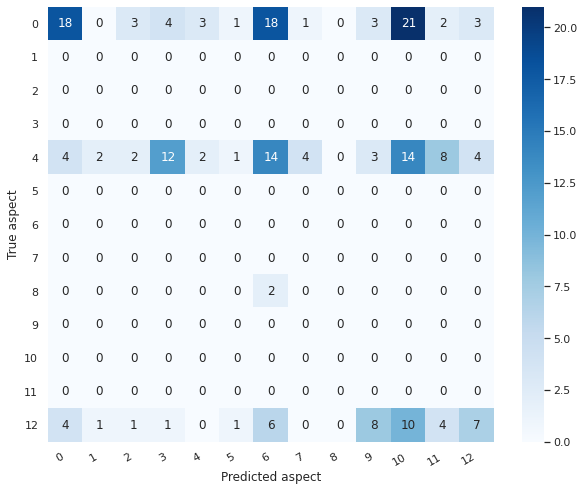

              precision    recall  f1-score   support

           0       0.60      0.27      0.37        77
           1       0.60      0.21      0.32        70
           2       0.03      1.00      0.07         2
           3       0.29      0.49      0.36        43

    accuracy                           0.31       192
   macro avg       0.38      0.49      0.28       192
weighted avg       0.52      0.31      0.35       192



In [289]:
plt.figure(figsize=(10,8))

df_cm = pd.DataFrame(cm)
show_confusion_matrix(df_cm, 'aspect')
print(classification_report(real_valuesAspect, predictionsAspect))

# 5) Qualitative Analysis

In [290]:
# SAVING MODELS
from pickle import dump, load
#dump(pipe1, open('gdrive/MyDrive/NLP_Project/pipe_W2V_Sent.pkl', 'wb'))
#dump(pipe2, open('gdrive/MyDrive/NLP_Project/pipe_W2V_Asp.pkl', 'wb'))
#dump(pol_wv, open('gdrive/MyDrive/NLP_Project/polwv_W2V_tokenizer.pkl', 'wb'))
torch.save(sentiment_model, 'gdrive/MyDrive/NLP_Project/sent_BERT.pth')
torch.save(aspect_model, 'gdrive/MyDrive/NLP_Project/aspect_BERT.pth')

In [294]:
#OPENING MODELS
pipe1 = load(open('gdrive/MyDrive/NLP_Project/pipe_W2V_Sent.pkl', 'rb'))
pipe2 = load(open('gdrive/MyDrive/NLP_Project/pipe_W2V_Asp.pkl', 'rb'))
pol_wv = load(open('gdrive/MyDrive/NLP_Project/polwv_W2V_tokenizer.pkl', 'rb'))
sentiment_model = torch.load('gdrive/MyDrive/NLP_Project/sent_BERT.pth')
aspect_model = torch.load('gdrive/MyDrive/NLP_Project/aspect_BERT.pth')

## Word2Vec

In [ ]:
def get_prediction_textW2VEC(model1, model2, tokenizer, classes1, classes2, review_text):

  dekotenized_text = detokenize_url_hashtags([review_text])
  X_review = tokens2vectors(dekotenized_text, tokenizer)
  y_pred1 = model1.predict(X_review)
  y_pred2 = model2.predict(X_review)

  return {'text':review_text, 'pred_model1':classes1[y_pred1], 'pred_model2':classes2[y_pred2]}

## Bert

In [ ]:
def get_prediction_text(model1, model2, classes1, classes2, review_text):

  dekotenized_text = detokenize_url_hashtags([review_text])
  review_df = pd.DataFrame({'sentence':dekotenized_text, 'label':[0]})
  review_set = ProgressiveIssuesDataSet(review_df.reset_index(drop=True), maxlen=30,  model_name='bert-base-uncased')
  review_loader = DataLoader(review_set, batch_size = 1, num_workers = 1)

  model1 = model1.eval()
  model2 = model2.eval()

  with torch.no_grad():
    for it, (seq, attn_masks, labels) in list(enumerate(review_loader)):
      outputs1 = model1(
        seq=seq,
        attn_masks= attn_masks
      )

      _, preds1 = torch.max(outputs1, dim=1)
        
      outputs2 = model2(
        seq=seq,
        attn_masks= attn_masks
      )

      _, preds2 = torch.max(outputs2, dim=1)


  return {'text':review_text, 'pred_model1':classes1[preds1], 'pred_model2':classes2[preds2]}

Tweet de @lazyuniverses : "the hijab ban in France is more than enough evidence that if your feminism isn't DECOLONIAL, it is also a tool for imperialist oppression"


In [295]:
review_text = "the hijab ban in France is more than enough evidence that if your feminism isn't DECOLONIAL, it is also a tool for imperialist oppression"
get_prediction_text(sentiment_model, aspect_model, le_classes, le_classesAspect, review_text)

100%|██████████| 1/1 [00:00<00:00, 302.73it/s]


{'pred_model1': 'AGAINST',
 'pred_model2': 'Feminist Movement',
 'text': "the hijab ban in France is more than enough evidence that if your feminism isn't DECOLONIAL, it is also a tool for imperialist oppression"}

In [297]:
get_prediction_textW2VEC(pipe1, pipe2, pol_wv, le_classes, le_classesAspect, review_text)

100%|██████████| 1/1 [00:00<00:00, 2559.06it/s]


{'pred_model1': array(['AGAINST'], dtype=object),
 'pred_model2': array(['Hillary Clinton'], dtype=object),
 'text': "the hijab ban in France is more than enough evidence that if your feminism isn't DECOLONIAL, it is also a tool for imperialist oppression"}

Tweet de @AOC : "Cameras, chokehold bans, “retraining” funds, and similar reform measures do not ultimately solve what is a systemic problem.

That system will find a way - killings happen on camera, people are killed in other ways, retraining grows $ while often substituting for deeper measures."

In [292]:
review_text2 = "Cameras, chokehold bans, “retraining” funds, and similar reform measures do not ultimately solve what is a systemic problem. \n That system will find a way - killings happen on camera, people are killed in other ways, retraining grows $ while often substituting for deeper measures."
get_prediction_text(sentiment_model, aspect_model, le_classes, le_classesAspect, review_text2)

100%|██████████| 1/1 [00:00<00:00, 1006.79it/s]


{'pred_model1': 'NONE OF THE ABOVE',
 'pred_model2': 'Hillary Clinton',
 'text': 'Cameras, chokehold bans, “retraining” funds, and similar reform measures do not ultimately solve what is a systemic problem. \n That system will find a way - killings happen on camera, people are killed in other ways, retraining grows $ while often substituting for deeper measures.'}

In [298]:
get_prediction_textW2VEC(pipe1, pipe2, pol_wv, le_classes, le_classesAspect, review_text2)

100%|██████████| 1/1 [00:00<00:00, 1271.00it/s]


{'pred_model1': array(['AGAINST'], dtype=object),
 'pred_model2': array(['Atheism'], dtype=object),
 'text': 'Cameras, chokehold bans, “retraining” funds, and similar reform measures do not ultimately solve what is a systemic problem. \n That system will find a way - killings happen on camera, people are killed in other ways, retraining grows $ while often substituting for deeper measures.'}